# Example Usage
This notebook serves to demonstrate some of the key objects in the MKIDReadout Analysis package. The core idea is to start with a phase time stream object with photons and then apply this to an existing resonator oject using the measurment object. An example phase_timestream, resonator, and measurment is explored in this notebook.

In [1]:
import numpy as np

import mkidnoiseanalysis
from resonator import *
import copy
%matplotlib inline

In [2]:
# Generate a timestream proportional to the change in quasiparticle density
quasiparticle_timestream = QuasiparticleTimeStream(fs = 2e6, ts = 10000e-6)

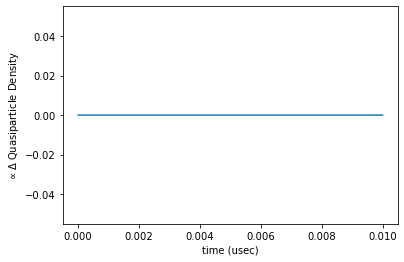

In [3]:
# Plot the raw data
quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

In [4]:
quasiparticle_timestream.data.shape

(20000,)

In [5]:
# Define a sudden change in quasiparticle density (caused by a photon)
quasiparticle_timestream.gen_quasiparticle_pulse(tf=30);

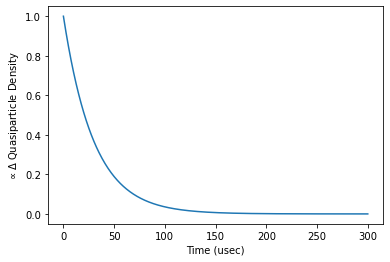

In [6]:
# Plot the pulse
quasiparticle_timestream.plot_pulse()

In [7]:
# Generate photon arrival times
quasiparticle_timestream.gen_photon_arrivals(cps=1000)

array([False, False, False, ..., False, False, False])

In [8]:
# Verify how many photons we got
print(quasiparticle_timestream.photon_arrivals.sum())

6


In [9]:
# Populate phase data with photon pulses
quasiparticle_timestream.populate_photons()

array([0., 0., 0., ..., 0., 0., 0.])

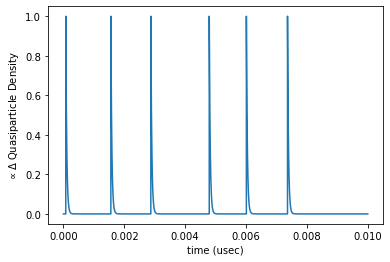

In [10]:
# Plot new timseries data
quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

# Resonator

In [11]:
# Create resonator and compute S21
resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1e4)
rf = RFElectronics(gain=(3.0, 0, 0), phase_delay=0, cable_delay=50e-9)
freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)
sweep = ResonatorSweep(resonator, freq, rf)

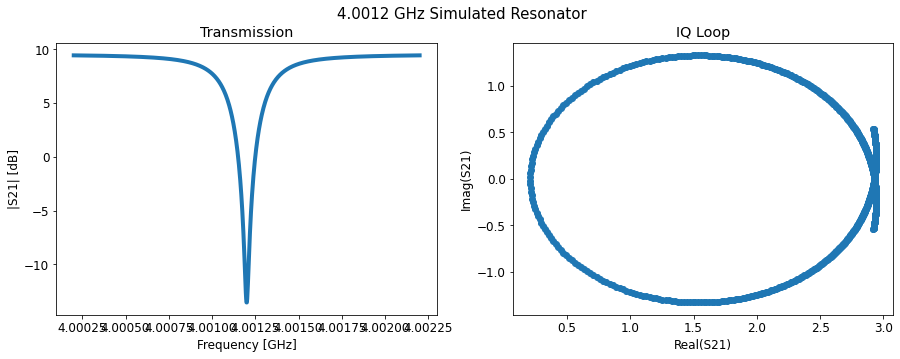

In [12]:
# Plot S21
sweep.plot_sweep()

# Single Photon Event

In [23]:
#Try just one photon and no TLS noise

def pulse(t, t0, tf=30):
    p = np.zeros_like(t)
    p[t >= t0] = -np.exp(-(t[t >= t0] - t0) / tf)
    return p

t = np.linspace(0, 500, 1000)*1e-6  # in sec
photon = pulse(t, 20e-6, tf=30e-6)

qp_timestream_single = copy.deepcopy(quasiparticle_timestream)
qp_timestream_single.tvec = t
qp_timestream_single.data = photon

In [24]:
# Define Measurment Object
lit_res_measurment = ReadoutPhotonResonator(resonator, qp_timestream_single, freq, rf)

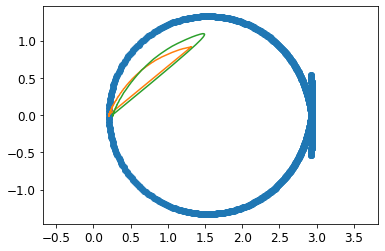

In [25]:
lit_res_measurment.plot_photon_response(sweep.s21)

In [26]:
theta1, d1 = lit_res_measurment.basic_coordinate_transformation()
theta2, d2 = lit_res_measurment.nick_coordinate_transformation()

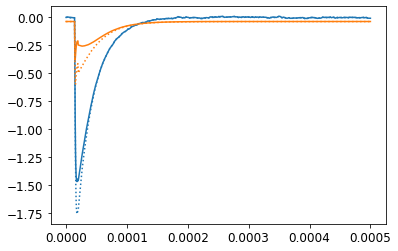

In [27]:
fig, axes = plt.subplots()
axes.plot(t, theta1, color='C0')
axes.plot(t, d1, color='C1')
axes.plot(t, theta2, linestyle=":", color='C0')
axes.plot(t, d2, linestyle=':', color='C1')

# Try to Look at the Repsonse with Multiple Photons
Now I'm going to perform the same measurment but this time I will use the original `quasiparticle_timestream` object with 12 photons.

In [29]:
lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)

In [30]:
theta1, d1 = lit_res_measurment.basic_coordinate_transformation()
theta2, d2 = lit_res_measurment.nick_coordinate_transformation()

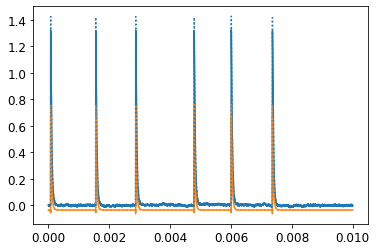

In [31]:
fig, axes = plt.subplots()
axes.plot(lit_res_measurment.photons.tvec, theta1, color='C0')
axes.plot(lit_res_measurment.photons.tvec, d1, color='C1')
axes.plot(lit_res_measurment.photons.tvec, theta2, linestyle=":", color='C0')
axes.plot(lit_res_measurment.photons.tvec, d2, linestyle=':', color='C1')

# Add Amplifier and Line Noise

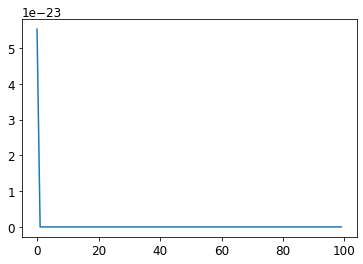

In [71]:
def gen_amp_noise(snr, points, seed=2):
    """ Flat PSD, white-noise generated from voltage fluctuations"""
    random_seed = np.random.default_rng(seed=seed)
    a_noise = 10 ** ((20 * np.log10(1 / np.sqrt(2)) - snr) / 10);  # input dBm of noise
    return np.sqrt(a_noise) * random_seed.normal(size=points)

In [85]:
noise = gen_amp_noise(30, quasiparticle_timestream.points)

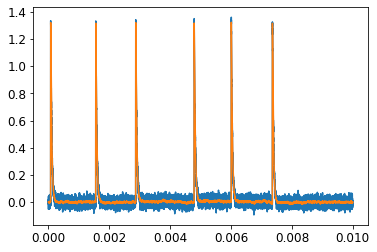

In [86]:
plt.plot(lit_res_measurment.photons.tvec, theta1+noise)
plt.plot(lit_res_measurment.photons.tvec, theta1)

In [41]:
quasiparticle_timestream.data.size

20000

In [42]:
theta1.size

20000